In [3]:
# ---------- 1. Load libraries ----------
import pandas as pd
import numpy as np
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ---------- 2. File paths (adjust if you moved files) ----------
DATA_DIR = Path("/content")
TXN_FILE = DATA_DIR / "QVI_transaction_data.xlsx"
CUST_FILE = DATA_DIR / "QVI_purchase_behaviour.csv"

# ---------- 3. Load datasets ----------
# transaction file in Excel; if it's CSV fallback to CSV read
if TXN_FILE.exists():
    txn = pd.read_excel(TXN_FILE)
else:
    # fallback (if user saved as CSV)
    txn = pd.read_csv(DATA_DIR / "QVI_transaction_data.csv")

cust = pd.read_csv(CUST_FILE)

In [4]:
# ---------- 4. Quick structure checks ----------
print("=== TRANSACTION: shape, dtypes ===")
print(txn.shape)
print(txn.dtypes)
print("\n=== CUSTOMER: shape, dtypes ===")
print(cust.shape)
print(cust.dtypes)

=== TRANSACTION: shape, dtypes ===
(264836, 8)
DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object

=== CUSTOMER: shape, dtypes ===
(72637, 3)
LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object


In [8]:
# ---------- 5. Convert Excel serial DATE -> datetime if needed ----------
# Many R solutions use as.Date on an Excel numeric date; check if DATE is numeric
if np.issubdtype(txn['DATE'].dtype, np.number):
    # Excel origin for pandas must be '1899-12-30' to match Excel's serial numbers
    txn['DATE'] = pd.to_datetime(txn['DATE'], unit='D', origin='1899-12-30')
    print("\nConverted TRANSACTION.DATE from Excel serial -> datetime.")
else:
    # If it's already an object/string, try coercing to datetime for safety
    txn['DATE'] = pd.to_datetime(txn['DATE'], errors='coerce')
    print("\nCoerced TRANSACTION.DATE to datetime (non-numeric path).")

# ---------- 6. Look at top rows to sanity-check content ----------
print("\n--- Sample transactions ---")
display(txn.head(5))
print("\n--- Sample customers ---")
display(cust.head(5))






Coerced TRANSACTION.DATE to datetime (non-numeric path).

--- Sample transactions ---


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8



--- Sample customers ---


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [9]:
# ---------- 7. Summary checks: nulls, basic numeric summaries, outlier checks ----------
print("\n=== Null counts (transactions) ===")
print(txn.isnull().sum())
print("\n=== Null counts (customers) ===")
print(cust.isnull().sum())

print("\n=== Basic numeric summary (transactions) ===")
display(txn.describe(include=[np.number]).T[['count','mean','std','min','25%','50%','75%','max']])

# Check for likely quantity outliers
print("\nMax PROD_QTY:", txn["PROD_QTY"].max())
print("Rows with PROD_QTY >= 100:", (txn["PROD_QTY"] >= 100).sum())

print("\nMax TOT_SALES:", txn["TOT_SALES"].max())
print("Rows with TOT_SALES >= 1000:", (txn["TOT_SALES"] >= 1000).sum())

print("\nUnique loyalty cards:", txn["LYLTY_CARD_NBR"].nunique())

# ---------- Summarise the data to check for nulls and possible outliers ----------


=== Null counts (transactions) ===
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

=== Null counts (customers) ===
LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

=== Basic numeric summary (transactions) ===


,count,mean,std,min,25%,50%,75%,max
STORE_NBR,264836.0,135.080110,76.784180,1.0,70.0,130.0,203.00,272.0
LYLTY_CARD_NBR,264836.0,135549.476404,80579.978022,1000.0,70021.0,130357.5,203094.25,2373711.0
TXN_ID,264836.0,135158.310815,78133.026026,1.0,67601.5,135137.5,202701.25,2415841.0
PROD_NBR,264836.0,56.583157,32.826638,1.0,28.0,56.0,85.00,114.0
PROD_QTY,264836.0,1.907309,0.643654,1.0,2.0,2.0,2.00,200.0
TOT_SALES,264836.0,7.304200,3.083226,1.5,5.4,7.4,9.20,650.0



Max PROD_QTY: 200
Rows with PROD_QTY >= 100: 2

Max TOT_SALES: 650.0
Rows with TOT_SALES >= 1000: 0

Unique loyalty cards: 72637


In [11]:
# ---------- B. Examine PROD_NAME (similar to R: transactionData[, .N, PROD_NAME]) ----------
print("\n=== Products and their counts (top 20) ===")
display(txn["PROD_NAME"].value_counts().head(20))

# Show total number of unique products
print("\nTotal unique product names:", txn["PROD_NAME"].nunique())



=== Products and their counts (top 20) ===


,count
PROD_NAME,
Kettle Mozzarella Basil & Pesto 175g,3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g,3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g,3269
Tyrrells Crisps Ched & Chives 165g,3268
Cobs Popd Sea Salt Chips 110g,3265
Kettle 135g Swt Pot Sea Salt,3257
Tostitos Splash Of Lime 175g,3252
Infuzions Thai SweetChili PotatoMix 110g,3242
Smiths Crnkle Chip Orgnl Big Bag 380g,3233



Total unique product names: 114


In [17]:
# ---------- C. Check if all products are chips by analyzing words in PROD_NAME ----------

# 1) Get all product names
unique_products = txn["PROD_NAME"].unique()

# 2) Split each name into words
all_words = []
for name in unique_products:
    all_words.extend(name.split())
# 2) Split each name into words
all_words = []
for name in unique_products:
    all_words.extend(name.split())

# 3) Convert into DataFrame
words_df = pd.DataFrame({"word": all_words})

print("\n=== Sample raw words extracted from product names ===")
display(words_df.head())


# 4) Remove words with digits (like '175g', '150g') -> not useful for category identification
words_df = words_df[~words_df["word"].str.contains(r"\d")]

# 5) Keep only alphabetic words (remove &, punctuation, etc.)
words_df = words_df[words_df["word"].str.contains(r"[A-Za-z]")]

# 6) Count frequency of words
word_counts = words_df["word"].value_counts()

print("\n=== Most common words in product names (similar to R output) ===")
display(word_counts.head(20))


=== Sample raw words extracted from product names ===


,word
0,Natural
1,Chip
2,Compny
3,SeaSalt175g
4,CCs



=== Most common words in product names (similar to R output) ===


,count
word,
Chips,21
Smiths,16
Cut,14
Crinkle,14
Kettle,13
Salt,12
Cheese,12
Original,10
Chip,9


In [18]:
# ---------- D. (Optional) Remove salsa products if needed ----------
# R says remove salsa, but our dataset only has Doritos Salsa 300g (still a chip dip).
# To follow R exactly, we show how to filter them, but NOT remove yet unless needed.

salsa_rows = txn[txn["PROD_NAME"].str.contains("salsa", case=False)]
print("\n=== Products containing 'salsa' ===")
display(salsa_rows.head())

# If you want to remove salsa uncomment next line (R did this step)
# txn = txn[~txn["PROD_NAME"].str.contains("salsa", case=False)]



=== Products containing 'salsa' ===


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
25,2019-05-15,39,39144,35506,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
32,2019-05-20,45,45127,41122,64,Red Rock Deli SR Salsa & Mzzrlla 150g,2,5.4
44,2018-08-18,56,56013,50090,39,Smiths Crinkle Cut Tomato Salsa 150g,1,2.6
63,2019-05-15,82,82480,82047,101,Doritos Salsa Medium 300g,1,2.6


In [19]:
# ---------- E. Summary statistics (same as R: summary(transactionData)) ----------
print("\n=== Summary statistics for numeric columns ===")
display(txn.describe().T)

print("\nNulls per column:")
print(txn.isnull().sum())


=== Summary statistics for numeric columns ===


,count,mean,min,25%,50%,75%,max,std
DATE,264836,2018-12-30 00:52:12.879215616,2018-07-01 00:00:00,2018-09-30 00:00:00,2018-12-30 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,NaN
STORE_NBR,264836.0,135.08011,1.0,70.0,130.0,203.0,272.0,76.78418
LYLTY_CARD_NBR,264836.0,135549.476404,1000.0,70021.0,130357.5,203094.25,2373711.0,80579.978022
TXN_ID,264836.0,135158.310815,1.0,67601.5,135137.5,202701.25,2415841.0,78133.026026
PROD_NBR,264836.0,56.583157,1.0,28.0,56.0,85.0,114.0,32.826638
PROD_QTY,264836.0,1.907309,1.0,2.0,2.0,2.0,200.0,0.643654
TOT_SALES,264836.0,7.3042,1.5,5.4,7.4,9.2,650.0,3.083226



Nulls per column:
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


In [23]:
# ---------- F. Find extreme outlier in PROD_QTY (same as R: PROD_QTY == 200) ----------
qty_outliers = txn[txn["PROD_QTY"] == 200]
print("\n=== Rows where PROD_QTY == 200 (potential commercial purchases) ===")
display(qty_outliers)

# What loyalty card is associated with these?
print("\nOutlier loyalty card numbers:", qty_outliers["LYLTY_CARD_NBR"].unique())

# ---------- G. Investigate transactions of that customer ----------
outlier_card = 226000  # from R solution

print(f"\n=== All transactions of loyalty card {outlier_card} ===")
display(txn[txn["LYLTY_CARD_NBR"] == outlier_card])




=== Rows where PROD_QTY == 200 (potential commercial purchases) ===


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0



Outlier loyalty card numbers: [226000]

=== All transactions of loyalty card 226000 ===


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [24]:
# ---------- H. Remove this outlier customer ----------
print("\nRemoving customer 226000 (commercial buyer)...")
txn = txn[txn["LYLTY_CARD_NBR"] != outlier_card]


Removing customer 226000 (commercial buyer)...


In [25]:
# ---------- I. Re-summarise cleaned dataset (same as R: summary(transactionData)) ----------
print("\n=== Summary AFTER removing outlier ===")
display(txn.describe().T)

print("\nNulls after cleaning:", txn.isnull().sum().sum())
print("Remaining rows:", txn.shape[0])


=== Summary AFTER removing outlier ===


,count,mean,min,25%,50%,75%,max,std
DATE,264834,2018-12-30 00:52:10.292938240,2018-07-01 00:00:00,2018-09-30 00:00:00,2018-12-30 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,NaN
STORE_NBR,264834.0,135.079423,1.0,70.0,130.0,203.0,272.0,76.784063
LYLTY_CARD_NBR,264834.0,135548.793331,1000.0,70021.0,130357.0,203094.0,2373711.0,80579.898912
TXN_ID,264834.0,135157.623236,1.0,67600.5,135136.5,202699.75,2415841.0,78132.920436
PROD_NBR,264834.0,56.583554,1.0,28.0,56.0,85.0,114.0,32.826444
PROD_QTY,264834.0,1.905813,1.0,2.0,2.0,2.0,5.0,0.343436
TOT_SALES,264834.0,7.299346,1.5,5.4,7.4,9.2,29.5,2.527241



Nulls after cleaning: 0
Remaining rows: 264834



# 🟦 TRANSACTIONS PER DAY + MISSING DATE CHECK + TIME SERIES PLOT


In [26]:
import matplotlib.pyplot as plt

# ---------- 1. Count number of transactions per DATE ----------
transactions_per_day = txn.groupby("DATE").size().reset_index(name="N")

print("\nNumber of unique dates in dataset:", transactions_per_day.shape[0])
print("Expected number of days (Jul 1 2018 → Jun 30 2019): 365")
print("\nSample of transaction counts per day:")
display(transactions_per_day.head())



Number of unique dates in dataset: 364
Expected number of days (Jul 1 2018 → Jun 30 2019): 365

Sample of transaction counts per day:


,DATE,N
0,2018-07-01,724
1,2018-07-02,711
2,2018-07-03,722
3,2018-07-04,714
4,2018-07-05,712


In [34]:
# ---------- 2. Create full date sequence from 1 Jul 2018 to 30 Jun 2019 ----------
full_dates = pd.DataFrame({
    "DATE": pd.date_range(start="2018-07-01", end="2019-06-30", freq="D")
})

# LEFT JOIN full date list with actual transaction counts
transactions_full = full_dates.merge(transactions_per_day, on="DATE", how="left")

# Replace NaN values with 0 transactions
transactions_full["N"] = transactions_full["N"].fillna(0)

print("\nFull merged date table (first 10 rows):")
display(transactions_full.head(10))


Full merged date table (first 10 rows):


,DATE,N
0,2018-07-01,724.0
1,2018-07-02,711.0
2,2018-07-03,722.0
3,2018-07-04,714.0
4,2018-07-05,712.0
5,2018-07-06,762.0
6,2018-07-07,750.0
7,2018-07-08,696.0
8,2018-07-09,749.0
9,2018-07-10,705.0


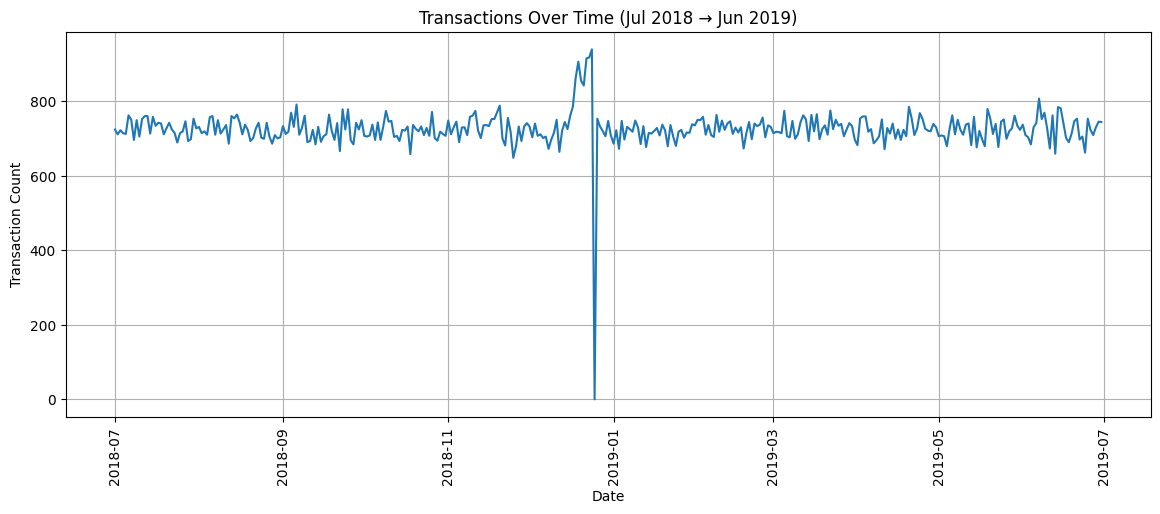

In [37]:
# ---------- 3. Plot: Transactions over time (full year) ----------
plt.figure(figsize=(14,5))
plt.plot(transactions_full["DATE"], transactions_full["N"])
plt.title("Transactions Over Time (Jul 2018 → Jun 2019)")
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


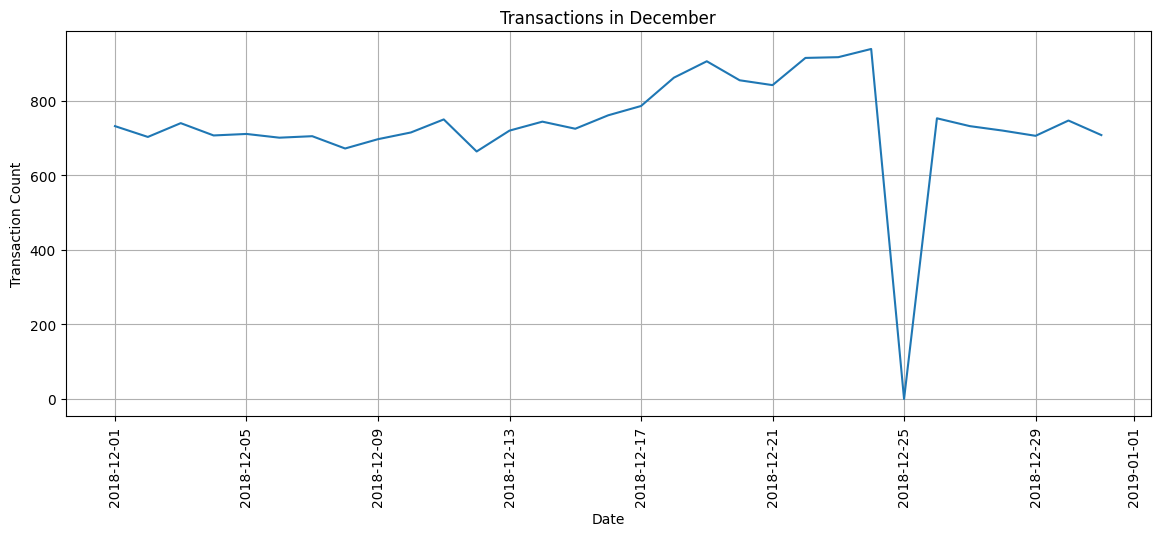

In [40]:
# ---------- 4. Zoom in: December sales pattern ----------
december_data = transactions_full[transactions_full["DATE"].dt.month == 12]

plt.figure(figsize=(14,5))
plt.plot(december_data["DATE"], december_data["N"])
plt.title("Transactions in December")
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


# 🟦 PACK SIZE CREATION & EXPLORATION (Before merging)

In [57]:
import re
import numpy as np

def extract_pack_size(name):
    name = str(name).lower()

    # Primary: extract numbers followed by 'g' → e.g. "170g"
    match = re.search(r'(\d{2,3})\s*g', name)
    if match:
        return int(match.group(1))

    # Fallback: extract any 2–3 digit number
    match2 = re.search(r'(\d{2,3})', name)
    if match2:
        return int(match2.group(1))

    return np.nan  # if nothing found

txn['PACK_SIZE'] = txn['PROD_NAME'].apply(extract_pack_size)

print("PACK_SIZE created. Sample:")
print(txn[['PROD_NAME','PACK_SIZE']].head())


PACK_SIZE created. Sample:
                                  PROD_NAME  PACK_SIZE
0    Natural Chip        Compny SeaSalt175g        175
1                  CCs Nacho Cheese    175g        175
2    Smiths Crinkle Cut  Chips Chicken 170g        170
3    Smiths Chip Thinly  S/Cream&Onion 175g        175
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g        150


In [58]:
# A. Reconfirm PACK_SIZE (extracted earlier) & count occurrences
pack_counts = (
    txn.groupby("PACK_SIZE")
       .size()
       .reset_index(name="N")
       .sort_values("PACK_SIZE")
)

print("\nPACK_SIZE distribution:")
display(pack_counts)



PACK_SIZE distribution:


,PACK_SIZE,N
0,70,1507
1,90,3008
2,110,22387
3,125,1454
4,134,25102
5,135,3257
6,150,43131
7,160,2970
8,165,15297
9,170,19983


In [59]:
# B. Check sample rows to verify PACK_SIZE is correct
print("\nSample rows with PACK_SIZE extracted:")
display(txn.head()[["PROD_NAME", "PROD_QTY", "TOT_SALES", "PACK_SIZE"]])


Sample rows with PACK_SIZE extracted:


,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,Natural Chip Compny SeaSalt175g,2,6.0,175
1,CCs Nacho Cheese 175g,3,6.3,175
2,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


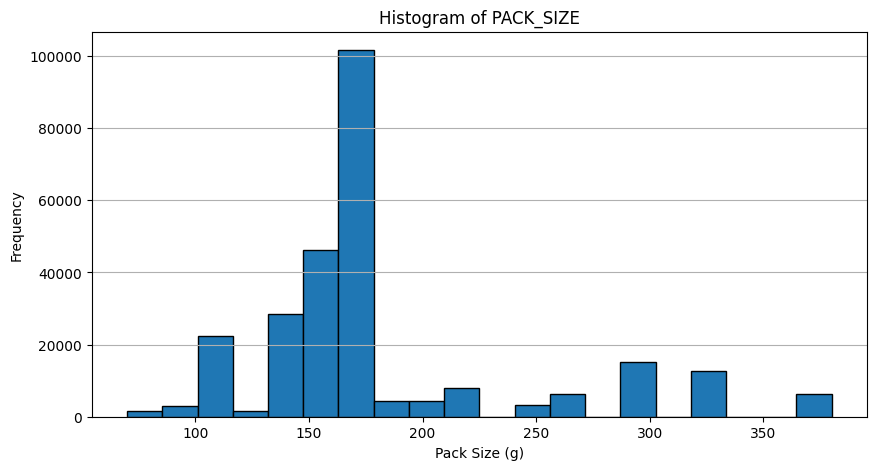

In [60]:
# C. Plot histogram of PACK_SIZE (categorical but numeric)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(txn["PACK_SIZE"], bins=20, edgecolor="black")
plt.title("Histogram of PACK_SIZE")
plt.xlabel("Pack Size (g)")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

# 🟦 BRAND EXTRACTION & BRAND CLEANING

In [62]:
# Create BRAND column (first word of PROD_NAME in uppercase)
txn["BRAND"] = txn["PROD_NAME"].str.split().str[0].str.upper()

print("BRAND column created. Sample:")
display(txn[["PROD_NAME", "BRAND"]].head())


BRAND column created. Sample:


,PROD_NAME,BRAND
0,Natural Chip Compny SeaSalt175g,NATURAL
1,CCs Nacho Cheese 175g,CCS
2,Smiths Crinkle Cut Chips Chicken 170g,SMITHS
3,Smiths Chip Thinly S/Cream&Onion 175g,SMITHS
4,Kettle Tortilla ChpsHny&Jlpno Chili 150g,KETTLE


In [63]:
# Count raw brands BEFORE cleaning
print("\nTop raw BRAND counts (before cleaning):")
display(txn["BRAND"].value_counts().head(20))



Top raw BRAND counts (before cleaning):


,count
BRAND,
KETTLE,41288
SMITHS,28860
PRINGLES,25102
DORITOS,24962
THINS,14075
RRD,11894
INFUZIONS,11057
WW,10320
COBS,9693


In [64]:
# Cleaning brand names (full mapping from R)
brand_mapping = {
    "RED": "RRD",
    "SNBTS": "SUNBITES",
    "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS",
    "SMITH": "SMITHS",
    "NCC": "NATURAL",
    "DORITO": "DORITOS",
    "GRAIN": "GRNWVES"
}

In [65]:
txn["BRAND"] = txn["BRAND"].replace(brand_mapping)

# Count brands AFTER cleaning
print("\nBrand counts after cleaning:")
display(
    txn["BRAND"]
    .value_counts()
    .sort_index()
    .reset_index(name="N")
    .rename(columns={"index":"BRAND"})
)



Brand counts after cleaning:


,BRAND,N
0,BURGER,1564
1,CCS,4551
2,CHEETOS,2927
3,CHEEZELS,4603
4,COBS,9693
5,DORITOS,28145
6,FRENCH,1418
7,GRNWVES,7740
8,INFUZIONS,14201
9,KETTLE,41288


# 🟦 EXAMINING CUSTOMER DATA (structure + summaries)

In [66]:

print("\n=== Structure of customer data ===")
print(cust.info())

print("\n=== Summary (describe) ===")
display(cust.describe(include="all"))

print("\n=== Value counts: LIFESTAGE ===")
display(cust["LIFESTAGE"].value_counts())

print("\n=== Value counts: PREMIUM_CUSTOMER ===")
display(cust["PREMIUM_CUSTOMER"].value_counts())


=== Structure of customer data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

=== Summary (describe) ===


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
count,7.263700e+04,72637,72637
unique,NaN,7,3
top,NaN,RETIREES,Mainstream
freq,NaN,14805,29245
mean,1.361859e+05,NaN,NaN
std,8.989293e+04,NaN,NaN
min,1.000000e+03,NaN,NaN
25%,6.620200e+04,NaN,NaN
50%,1.340400e+05,NaN,NaN
75%,2.033750e+05,NaN,NaN



=== Value counts: LIFESTAGE ===


,count
LIFESTAGE,
RETIREES,14805
OLDER SINGLES/COUPLES,14609
YOUNG SINGLES/COUPLES,14441
OLDER FAMILIES,9780
YOUNG FAMILIES,9178
MIDAGE SINGLES/COUPLES,7275
NEW FAMILIES,2549



=== Value counts: PREMIUM_CUSTOMER ===


,count
PREMIUM_CUSTOMER,
Mainstream,29245
Budget,24470
Premium,18922


In [70]:
# ===============================================================
# 1. MERGE TRANSACTION DATA WITH CUSTOMER DATA


data = txn.merge(cust, on="LYLTY_CARD_NBR", how="left")

print("Merged dataset shape:", data.shape)
print("Should match original txn row count:", txn.shape[0])

# Check for unmatched customers
print("\nRows with missing LIFESTAGE:", data["LIFESTAGE"].isnull().sum())
print("Rows with missing PREMIUM_CUSTOMER:", data["PREMIUM_CUSTOMER"].isnull().sum())


Merged dataset shape: (264834, 12)
Should match original txn row count: 264834

Rows with missing LIFESTAGE: 0
Rows with missing PREMIUM_CUSTOMER: 0


In [71]:
# 2. TOTAL SALES BY LIFESTAGE × PREMIUM_CUSTOMER
# ===============================================================

sales = (
    data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"]
    .sum()
    .reset_index()
    .sort_values("TOT_SALES", ascending=False)
)

print("\nTotal sales by segment:")
display(sales)


Total sales by segment:


,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
6,OLDER FAMILIES,Budget,168363.25
19,YOUNG SINGLES/COUPLES,Mainstream,157621.60
13,RETIREES,Mainstream,155677.05
15,YOUNG FAMILIES,Budget,139345.85
9,OLDER SINGLES/COUPLES,Budget,136769.80
10,OLDER SINGLES/COUPLES,Mainstream,133393.80
11,OLDER SINGLES/COUPLES,Premium,132263.15
12,RETIREES,Budget,113147.80
7,OLDER FAMILIES,Mainstream,103445.55
14,RETIREES,Premium,97646.05


In [76]:
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,KETTLE,MIDAGE SINGLES/COUPLES,Budget


In [72]:
# 3. NUMBER OF UNIQUE CUSTOMERS BY SEGMENT
# ===============================================================

customers = (
    data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"]
    .nunique()
    .reset_index(name="CUSTOMERS")
    .sort_values("CUSTOMERS", ascending=False)
)

print("\nNumber of customers in each segment:")
display(customers)


Number of customers in each segment:


,LIFESTAGE,PREMIUM_CUSTOMER,CUSTOMERS
19,YOUNG SINGLES/COUPLES,Mainstream,8088
13,RETIREES,Mainstream,6479
10,OLDER SINGLES/COUPLES,Mainstream,4930
9,OLDER SINGLES/COUPLES,Budget,4929
11,OLDER SINGLES/COUPLES,Premium,4750
6,OLDER FAMILIES,Budget,4675
12,RETIREES,Budget,4454
15,YOUNG FAMILIES,Budget,4017
14,RETIREES,Premium,3872
18,YOUNG SINGLES/COUPLES,Budget,3779


In [73]:
# ===============================================================
# 4. AVERAGE UNITS OF CHIPS PER CUSTOMER
# ===============================================================

avg_units = (
    data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])
    .apply(lambda x: x["PROD_QTY"].sum() / x["LYLTY_CARD_NBR"].nunique())
    .reset_index(name="AVG_UNITS")
    .sort_values("AVG_UNITS", ascending=False)
)

print("\nAverage units per customer:")
display(avg_units)



Average units per customer:


,LIFESTAGE,PREMIUM_CUSTOMER,AVG_UNITS
7,OLDER FAMILIES,Mainstream,9.804309
6,OLDER FAMILIES,Budget,9.639572
8,OLDER FAMILIES,Premium,9.578091
15,YOUNG FAMILIES,Budget,9.238486
17,YOUNG FAMILIES,Premium,9.209207
16,YOUNG FAMILIES,Mainstream,9.180352
11,OLDER SINGLES/COUPLES,Premium,7.154947
9,OLDER SINGLES/COUPLES,Budget,7.145466
10,OLDER SINGLES/COUPLES,Mainstream,7.098783
1,MIDAGE SINGLES/COUPLES,Mainstream,6.796108


In [74]:
# ===============================================================
# 5. AVERAGE PRICE PER UNIT OF CHIPS
# ===============================================================

avg_price = (
    data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])
    .apply(lambda x: x["TOT_SALES"].sum() / x["PROD_QTY"].sum())
    .reset_index(name="AVG_PRICE")
    .sort_values("AVG_PRICE", ascending=False)
)

print("\nAverage price per unit:")
display(avg_price)



Average price per unit:


,LIFESTAGE,PREMIUM_CUSTOMER,AVG_PRICE
19,YOUNG SINGLES/COUPLES,Mainstream,4.080079
1,MIDAGE SINGLES/COUPLES,Mainstream,4.000346
4,NEW FAMILIES,Mainstream,3.939315
3,NEW FAMILIES,Budget,3.936178
12,RETIREES,Budget,3.933660
14,RETIREES,Premium,3.924050
11,OLDER SINGLES/COUPLES,Premium,3.891695
5,NEW FAMILIES,Premium,3.886067
9,OLDER SINGLES/COUPLES,Budget,3.883299
13,RETIREES,Mainstream,3.842170


In [77]:
# ===============================================================
# 6. T-TEST (Mainstream young/mid singles/couples vs Others)
# ===============================================================

from scipy.stats import ttest_ind

data["PRICE_PER_UNIT"] = data["TOT_SALES"] / data["PROD_QTY"]

target = data[
    (data["LIFESTAGE"].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (data["PREMIUM_CUSTOMER"] == "Mainstream")
]["PRICE_PER_UNIT"]

others = data[
    (data["LIFESTAGE"].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (data["PREMIUM_CUSTOMER"] != "Mainstream")
]["PRICE_PER_UNIT"]

t_stat, p_val = ttest_ind(target, others, equal_var=False)

print("\nT-test results:")
print("t-statistic:", t_stat)
print("p-value:", p_val)
print("Mean price mainstream:", target.mean())
print("Mean price others:", others.mean())



T-test results:
t-statistic: 40.60989476220132
p-value: 0.0
Mean price mainstream: 4.045586042532388
Mean price others: 3.688165443861052


Deep Dive: Mainstream Young Singles/Couples

In [79]:
#7A. Split data into target segment vs others

segment = data[
    (data["LIFESTAGE"] == "YOUNG SINGLES/COUPLES") &
    (data["PREMIUM_CUSTOMER"] == "Mainstream")
]

other = data[
    ~(
        (data["LIFESTAGE"] == "YOUNG SINGLES/COUPLES") &
        (data["PREMIUM_CUSTOMER"] == "Mainstream")
    )
]


In [80]:
# ===============================================================
# 7A. BRAND AFFINITY
# ===============================================================

quantity_segment = segment["PROD_QTY"].sum()
quantity_other = other["PROD_QTY"].sum()

seg_brand = (
    segment.groupby("BRAND")["PROD_QTY"].sum() / quantity_segment
)
oth_brand = (
    other.groupby("BRAND")["PROD_QTY"].sum() / quantity_other
)

brand_affinity = (
    pd.DataFrame({
        "targetSegment": seg_brand,
        "other": oth_brand
    })
    .fillna(0)
)

brand_affinity["affinityToBrand"] = (
    brand_affinity["targetSegment"] / brand_affinity["other"]
)

brand_affinity = brand_affinity.sort_values("affinityToBrand", ascending=False)

print("\nBrand affinity ranking:")
display(brand_affinity.head(10))



Brand affinity ranking:


,targetSegment,other,affinityToBrand
BRAND,,,
TYRRELLS,0.029587,0.023933,1.236235
TWISTIES,0.043306,0.035283,1.227401
KETTLE,0.185649,0.154216,1.203823
TOSTITOS,0.042581,0.035377,1.203638
OLD,0.041598,0.034753,1.196958
PRINGLES,0.111980,0.093743,1.194536
DORITOS,0.122877,0.105277,1.167176
COBS,0.041856,0.036375,1.150700
INFUZIONS,0.060649,0.053157,1.140947


In [81]:
# ===============================================================
# 7B. PACK SIZE AFFINITY
# ===============================================================

seg_pack = (
    segment.groupby("PACK_SIZE")["PROD_QTY"].sum() / quantity_segment
)
oth_pack = (
    other.groupby("PACK_SIZE")["PROD_QTY"].sum() / quantity_other
)

pack_affinity = pd.DataFrame({
    "targetSegment": seg_pack,
    "other": oth_pack
}).fillna(0)

pack_affinity["affinityToPack"] = (
    pack_affinity["targetSegment"] / pack_affinity["other"]
)

pack_affinity = pack_affinity.sort_values("affinityToPack", ascending=False)

print("\nPack size affinity ranking:")
display(pack_affinity.head(10))



Pack size affinity ranking:


,targetSegment,other,affinityToPack
PACK_SIZE,,,
270,0.029846,0.023377,1.276694
380,0.030156,0.023832,1.265361
330,0.057465,0.046727,1.229814
134,0.111980,0.093743,1.194536
110,0.099658,0.083642,1.191482
210,0.027309,0.023401,1.167002
135,0.013849,0.012180,1.136997
250,0.013460,0.011905,1.130611
170,0.075740,0.075440,1.003980
